In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tqdm import tqdm
print(tf.config.list_physical_devices('GPU'))

X_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/images_patched/'
Y_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/labels_png_patched/'

X_TRAIN_PATH_NEW = '../datasets/Dataset_KG/images/'
Y_TRAIN_PATH_NEW = '../datasets/Dataset_KG/masks/'
METADATA_PATH = '../datasets/Dataset_KG/Dataset_KG_metadata.xlsx'

# Some images have an obstructing label on them so we ignore those
IGNORE_IMAGES = [
    '10Cs 11_patch_8.png', 'U-510 coeur_Champ_1_1_5_patch_24.png', 'V-294 peau_Champ_1_1_1_patch_24.png', 'v-448 b mr_Champ_1_1_4_patch_24.png', 'W-441_Champ_1_1_4_patch_24.png',
]

def load_and_augment_data(image_path, mask_path, augment_data=True):
    images = []
    masks = []
    angles = [90, 180, 270]

    # Load metadata from the Excel file
    metadata = pd.read_excel(METADATA_PATH)

    for file in os.listdir(image_path):
        if file.endswith('.png') and file not in IGNORE_IMAGES:
            img = cv2.imread(os.path.join(image_path, file), cv2.IMREAD_GRAYSCALE)

            # Extract the corresponding metadata row for the current image
            meta_row = metadata[metadata['Image'] == file]
            if not meta_row.empty:
                material = meta_row['Material'].values[0]
                if material == 'Steel_QT':
                    material = 1
                elif material == 'Steel_2P':
                    material = 2
                elif material == 'Al':
                    material = 3
                
                etching = meta_row['Etching'].values[0]
                if etching == 'Schmitz':
                    etching = 1
                elif etching == 'Nital':
                    etching = 2
                elif etching == 'Barker':
                    etching = 3

                # Add metadata to image in the form of 2 new channels
                meta_channels = np.zeros((img.shape[0], img.shape[1], 2), dtype=np.float32)
                meta_channels[..., 0] = material
                meta_channels[..., 1] = etching
                
                img = np.concatenate([img[..., np.newaxis], meta_channels.astype(np.float32)], axis=-1)
            
            mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)

            if file == 'W-441_Champ_1_1_4_patch_22.png':
                global visualization_img
                visualization_img = img  # Store the image for visualization later
                global visualization_mask
                visualization_mask = mask  # Store the mask for visualization later
            else:
                images.append(img)
                masks.append(mask)

    augmented_images = []
    augmented_masks = []

    for img, mask in tqdm(zip(images, masks), total=len(images), desc="Augmenting data"):
        augmented_images.append(img)
        augmented_masks.append(mask)
        if augment_data:
            for angle in angles:
                rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
                rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
                augmented_images.append(rotated_img)
                augmented_masks.append(rotated_mask)

    return augmented_images, augmented_masks

n_classes = 2
#train_images, train_masks = load_and_augment_data(X_TRAIN_PATH, Y_TRAIN_PATH, False)
train_images, train_masks = load_and_augment_data(X_TRAIN_PATH_NEW, Y_TRAIN_PATH_NEW, False)

print("Number of training images:", len(train_images))
print("Shape of a single training image:", train_images[0].shape)
print("Number of training masks:", len(train_masks))
print("Shape of a single training mask:", train_masks[0].shape)

2025-06-22 17:54:52.346199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750607692.359544    4062 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750607692.365277    4062 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750607692.376452    4062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750607692.376480    4062 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750607692.376481    4062 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Augmenting data: 100%|██████████| 407/407 [00:00<00:00, 3026740.65it/s]

Number of training images: 407
Shape of a single training image: (512, 512, 3)
Number of training masks: 407
Shape of a single training mask: (512, 512)


In [ ]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))

        # Display image
        plt.subplot(1, 2, 1)
        plt.title(f"Image {i+1}")
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        # Display mask
        plt.subplot(1, 2, 2)
        plt.title(f"Mask {i+1}")
        plt.imshow(masks[i], cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
        plt.axis('off')

        plt.show()

# Display a couple of images and masks
display_images_and_masks(train_images, train_masks, num_samples=2)

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Turn the lists into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("Class values in Y_train:")
unique_classes = np.unique(Y_train)
print(unique_classes)   # [0 1 2 3]

# print shape of X_train and Y_train
print("Shape of X_train:", X_train.shape)  # (number_of_images, height, width, channels)
print("Shape of Y_train:", Y_train.shape)  # (number_of_images, height, width, channels)
# both are (76, 322, 322)

# Convert Y_train to categorical
from keras.utils import to_categorical

if n_classes == 2:
    # If binary classification, convert to binary masks
    Y_train = (Y_train > 0).astype(np.uint8)
    Y_test = (Y_test > 0).astype(np.uint8)

train_masks_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = train_masks_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))

test_masks_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = test_masks_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train.flatten()
)
# Normalize class weights
class_weights = class_weights / class_weights.sum()
print("Class weights:", class_weights)

# wrote them down here because they took forever to calculate on large dataset
#class_weights = [0.82500247, 0.17499753]

In [ ]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

def selfmade_model():
    import u_net
    model = u_net.unet_model_same_padding()
    return model

def selfmade_model_512():
    import u_net_512
    model = u_net_512.unet_model_same_padding()
    return model

def pretrained_model(X_train, X_test, n_classes):
    BACKBONE = 'resnet34'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    X_train = preprocess_input(X_train)
    X_test = preprocess_input(X_test)
    model = sm.Unet(backbone_name=BACKBONE, encoder_weights='imagenet', activation='softmax', classes=n_classes)
    return model

def compile_with_hybrid_loss(model):
    # Custom loss function combining Dice and Focal Loss and 2 different metrics
    LR = 0.0001
    optimizer = tf.keras.optimizers.Adam(LR)
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + focal_loss
    metrics = [
        sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
        sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
    ]
    model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

def compile_with_jaccard_loss(model):
    # This is what they used in the segmentation_models library tutorial
    # (https://github.com/qubvel/segmentation_models/blob/master/docs/tutorial.rst)
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])


import u_net_512
model = u_net_512.unet_model_same_padding(in_channels=3)
compile_with_hybrid_loss(model)



In [ ]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

def make_rgb_channels(X_train, X_test):
    # Ensure the input data has 3 channels by expanding dimensions
    # Necessary for resnet34 backbone
    X_train = np.expand_dims(X_train, axis=-1)
    X_train = np.repeat(X_train, 3, axis=-1)  # Repeat the single channel to create 3 channels

    X_test = np.expand_dims(X_test, axis=-1)
    X_test = np.repeat(X_test, 3, axis=-1)  # Repeat the single channel to create 3 channels

    return X_train, X_test

#X_train, X_test = make_rgb_channels(X_train, X_test)

history = model.fit(
    X_train,
    Y_train_cat,
    batch_size=2,
    verbose=1,
    epochs=50,
    validation_data=(X_test, Y_test_cat),
    shuffle=True,
    callbacks=[
        early_stopping,
        model_checkpoint
        ],
)

In [ ]:
model = tf.keras.models.load_model('best models/best_small_cross_entropy.keras')

In [ ]:
model = tf.keras.models.load_model('best models/best_large_focal_loss.keras', custom_objects={
    'jaccard_coeff_multiclass': u_net.jaccard_coeff_multiclass
})

In [2]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

model = tf.keras.models.load_model('best models/new dataset/best_small_own_mixed_fromstart.keras', compile=False)

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
class_weights = [0.82500247, 0.17499753]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
    sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
]

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

Segmentation Models: using `tf.keras` framework.


I0000 00:00:1750607706.709257    4062 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


In [ ]:
# Evaluate the model
# Evaluate the model in smaller batches to avoid running out of memory
loss, accuracy = model.evaluate(X_test, Y_test_cat, batch_size=4, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

In [ ]:
#IOU FOR OLD DATASET
y_pred = model.predict(X_test, batch_size=4)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(Y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = IOU_keras.total_cm.numpy()
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
from keras.metrics import MeanIoU

# IOU FOR NEW DATASET
y_pred_new = model.predict(X_test, batch_size=4)
y_pred_argmax_new = np.argmax(y_pred_new, axis=3)

# Using built-in Keras function to calculate Mean IoU
IOU_keras_new = MeanIoU(num_classes=n_classes)
IOU_keras_new.update_state(Y_test, y_pred_argmax_new)
print("Mean IoU for new dataset =", IOU_keras_new.result().numpy())

# To calculate IoU for each class
values_new = IOU_keras_new.total_cm.numpy()
print(values_new)
class1_IoU_new = values_new[0, 0] / (values_new[0, 0] + values_new[0, 1] + values_new[1, 0])
class2_IoU_new = values_new[1, 1] / (values_new[1, 1] + values_new[1, 0] + values_new[0, 1])

print("IoU for class1 (new dataset):", class1_IoU_new)
print("IoU for class2 (new dataset):", class2_IoU_new)

In [ ]:

# plot the training history
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)


I0000 00:00:1750607726.620635    5114 service.cc:152] XLA service 0x7f6c2802eac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750607726.620662    5114 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-06-22 17:55:26.632868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750607726.711099    5114 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1750607733.059805    5114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


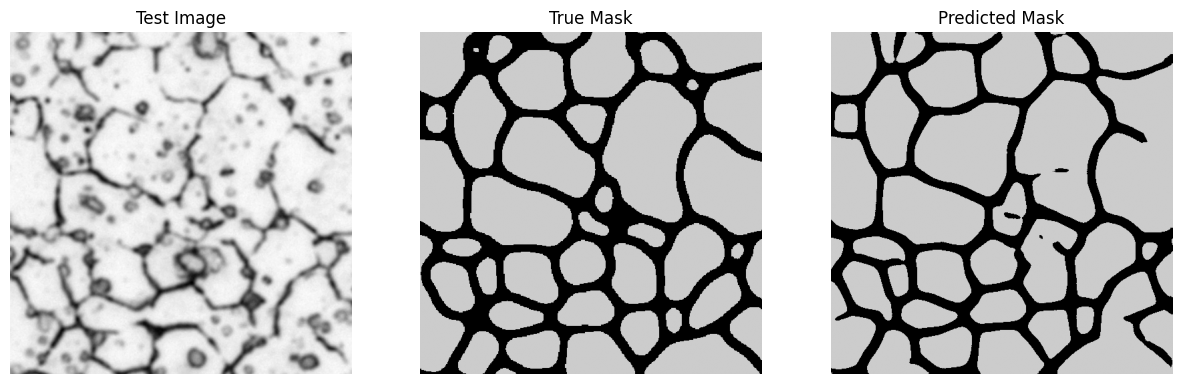

In [3]:
#random.seed(43)
# Pick a random test image
import matplotlib.pyplot as plt
#idx = random.randint(0, X_test.shape[0] - 1)
#test_img = X_test[idx]
#true_mask = Y_test[idx]
test_img = visualization_img
true_mask = visualization_mask

# Rotate the test image and true mask by 90 degrees
test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
true_mask = cv2.rotate(true_mask, cv2.ROTATE_90_CLOCKWISE)

# Predict the mask
pred_mask = model.predict(np.expand_dims(test_img, axis=0))
pred_mask = np.argmax(pred_mask, axis=-1)[0]

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.imshow(test_img[..., 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.show()
